In [379]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
    MinMaxScaler,
    FunctionTransformer
)
from sklearn.metrics import (
    roc_auc_score, 
    roc_curve,
    RocCurveDisplay,
    accuracy_score
)
from imblearn.over_sampling import RandomOverSampler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from utils import *
from model import FCNet
from train import solver

%load_ext autoreload
%autoreload 2

SEED = 42

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    'mps' if torch.backends.mps.is_available() else
    "cpu"
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [387]:
train_path = "../../ucla-stats-101-c-2024-summer-classification/train_class.csv"
train_csv = pd.read_csv(train_path)

test_path = "../../ucla-stats-101-c-2024-summer-classification/test_class.csv"
test_csv = pd.read_csv(test_path)

for col in train_csv.columns:
    if col not in set(test_csv.columns):
        print(col)

winner
name


In [388]:
train_csv.winner.value_counts()

winner
Trump    1942
Biden     389
Name: count, dtype: int64

In [389]:
_X = train_csv.drop(['name', 'winner'], axis=1)
_y = convert(train_csv.winner.to_numpy())

# initial split
_X, _X_test, y, y_test = train_test_split(
    _X, _y, test_size=0.2, stratify=_y, random_state=SEED
)

ros = RandomOverSampler(sampling_strategy='minority')
_X, y = ros.fit_resample(_X, y)

# train set and eval set
_X_train, _X_eval, y_train, y_eval = train_test_split(
    _X, y, test_size=0.1, stratify=y, random_state=SEED
)

_X_train = _X_train.drop(['id'], axis=1)
_X_eval = _X_eval.drop(['id'], axis=1)
_X_test = _X_test.drop(['id'], axis=1)

print('Feature Shapes')
print(f'\traw train: {_X_train.shape}')
print(f'\traw eval: {_X_eval.shape}')
print(f'\traw test: {_X_test.shape}\n')

print('Target Distributions:')
print(f'\ty_train: {pd.Series(y_train).value_counts().values}')
print(f'\ty_eval: {pd.Series(y_eval).value_counts().values}')
print(f'\ty_test: {pd.Series(y_test).value_counts().values}')

Feature Shapes
	raw train: (2795, 123)
	raw eval: (311, 123)
	raw test: (467, 123)

Target Distributions:
	y_train: [1398 1397]
	y_eval: [156 155]
	y_test: [389  78]


In [390]:
_X_train = engineer_features(_X_train)
_X_eval = engineer_features(_X_eval)
_X_test = engineer_features(_X_test)

print('Feature Shapes')
print(f'\traw train: {_X_train.shape}')
print(f'\traw eval: {_X_eval.shape}')
print(f'\traw test: {_X_test.shape}\n')

Feature Shapes
	raw train: (2795, 110)
	raw eval: (311, 110)
	raw test: (467, 110)



/Users/andywang/Documents/stats_101c_project/Trump_or_Biden/python/utils.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ratio_under_18'] = df['x0019e'] / df['x0001e']
/Users/andywang/Documents/stats_101c_project/Trump_or_Biden/python/utils.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ratio_18_over'] = df['x0021e'] / df['x0001e']
/Users/andywang/Documents/stats_101c_project/Trump_or_Biden/python/utils.py:54: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

In [391]:
categorical_columns = [
    'x2013_code'
]

one_hot_enc = OneHotEncoder(handle_unknown='ignore')

categorical_pipeline = Pipeline(
    [
        ('encoder', one_hot_enc)
    ]
)

numerical_columns = list(_X_train.loc[:, _X_train.columns != 'x2013_code'].columns)

imputer = SimpleImputer()
scaler = StandardScaler()

numerical_pipeline = Pipeline(
    [
        ('imputer', imputer),
        ('std_scaler', scaler)
    ]
)

pipeline = ColumnTransformer(
    [
        ('numerical', numerical_pipeline, numerical_columns),
        ('categorical', categorical_pipeline, categorical_columns)
    ]
)

pipeline.fit(_X_train)

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['total_votes', 'x0018e', 'x0020e', 'x0022e',
                                  'x0023e', 'x0025e', 'x0026e', 'x0027e',
                                  'x0029e', 'x0030e', 'x0031e', 'x0034e',
                                  'x0035e', 'x0037e', 'x0038e', 'x0039e',
                                  'x0044e', 'x0047e', 'x0048e', 'x0049e',
                                  'x0050e', 'x0051e', 'x0052e', 'x0053e',
                                  'x0054e', 'x0055e', 'x0056e', 'x0057e',
                                  'x0058e', 'x0059e', ...]),
                                ('categorical',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['x2013_code'])])

In [392]:
X_train = pipeline.transform(_X_train)
X_eval = pipeline.transform(_X_eval)
X_test = pipeline.transform(_X_test)

print('Transformed Feature Shapes:')
print(f'\ttrain: {X_train.shape}')
print(f'\teval: {X_eval.shape}')
print(f'\ttest: {X_test.shape}')

Transformed Feature Shapes:
	train: (2795, 115)
	eval: (311, 115)
	test: (467, 115)


In [393]:
# configs
BATCH_SIZE = 32
LR = 5e-4
EPOCHS = 10

In [394]:
train_dataset = CustomDataset(X_train, y_train)
eval_dataset = CustomDataset(X_eval, y_eval)

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE
)
eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE
)

In [395]:
num_hidden_to_try = [1, 2, 3, 4, 5]
hidden_sizes_to_try = [10, 20, 30, 60, 90, 120]
hidden_dropouts_to_try = [0.2, 0.4, 0.6, 0.8]

input_size = X_train.shape[1]
input_dropout = 0.8

ground_truth = torch.tensor(y_test).float()
bce = nn.BCELoss()
best_auc = 0.5
best_acc = 0.0
best_model = None
best_model_eval_loss = None

results = {
    'model': [],
    'params': [],
    'num_hidden_layers': [],
    'hidden_size': [],
    'hidden_layer_dropout': [],
    'auc': [],
    'acc': []
}

for num_hidden in tqdm(num_hidden_to_try):
    for hidden_size in hidden_sizes_to_try:
        for hidden_dropout in hidden_dropouts_to_try:
            hidden_sizes = [hidden_size for _ in range(num_hidden)]

            model = FCNet(
                input_size, 
                hidden_sizes,
                input_dropout,
                hidden_dropout
            )

            print(f'Trying {model.name}...')

            train_losses, eval_losses = solver(
                model, 
                train_dataloader, 
                eval_dataloader,
                LR,
                EPOCHS,
                False,
                100
            )

            with torch.no_grad():
                model.cpu()
                logits = model(
                    torch.from_numpy(X_test).to(torch.float32)
                ).squeeze()

            auc = roc_auc_score(ground_truth, logits)
            preds = get_preds(logits)
            acc = accuracy_score(ground_truth, preds)

            results['model'].append(model.name)
            results['params'].append(model.num_params)
            results['num_hidden_layers'].append(num_hidden)
            results['hidden_size'].append(hidden_size)
            results['hidden_layer_dropout'].append(hidden_dropout)
            results['auc'].append(auc)
            results['acc'].append(acc)

            if acc > best_acc:
                best_acc = acc
                best_model = model
                best_model_eval_loss = eval_losses
                print('==============================')
                print(f'New best model: {model.name}!')
                print(f'- hidden_size = {hidden_size}')
                print(f'- dropout = {hidden_dropout}')
                print(f'Accuracy = {acc:.5f}')
                print('==============================')

results_df = pd.DataFrame.from_dict(results).sort_values('acc', ascending=False)

  0%|          | 0/5 [00:00<?, ?it/s]

Trying 2-Layer FC-Net (1171 parameters, dropout = 0.2)...
New best model: 2-Layer FC-Net (1171 parameters, dropout = 0.2)!
- hidden_size = 10
- dropout = 0.2
Accuracy = 0.87152
Trying 2-Layer FC-Net (1171 parameters, dropout = 0.4)...
New best model: 2-Layer FC-Net (1171 parameters, dropout = 0.4)!
- hidden_size = 10
- dropout = 0.4
Accuracy = 0.87794
Trying 2-Layer FC-Net (1171 parameters, dropout = 0.6)...
Trying 2-Layer FC-Net (1171 parameters, dropout = 0.8)...
Trying 2-Layer FC-Net (2341 parameters, dropout = 0.2)...
Trying 2-Layer FC-Net (2341 parameters, dropout = 0.4)...
Trying 2-Layer FC-Net (2341 parameters, dropout = 0.6)...
Trying 2-Layer FC-Net (2341 parameters, dropout = 0.8)...
New best model: 2-Layer FC-Net (2341 parameters, dropout = 0.8)!
- hidden_size = 20
- dropout = 0.8
Accuracy = 0.88009
Trying 2-Layer FC-Net (3511 parameters, dropout = 0.2)...
Trying 2-Layer FC-Net (3511 parameters, dropout = 0.4)...
Trying 2-Layer FC-Net (3511 parameters, dropout = 0.6)...
Tryin

 20%|██        | 1/5 [01:19<05:19, 79.81s/it]

Trying 3-Layer FC-Net (1281 parameters, dropout = 0.2)...
Trying 3-Layer FC-Net (1281 parameters, dropout = 0.4)...
Trying 3-Layer FC-Net (1281 parameters, dropout = 0.6)...
Trying 3-Layer FC-Net (1281 parameters, dropout = 0.8)...
Trying 3-Layer FC-Net (2761 parameters, dropout = 0.2)...
Trying 3-Layer FC-Net (2761 parameters, dropout = 0.4)...
Trying 3-Layer FC-Net (2761 parameters, dropout = 0.6)...
Trying 3-Layer FC-Net (2761 parameters, dropout = 0.8)...
Trying 3-Layer FC-Net (4441 parameters, dropout = 0.2)...
New best model: 3-Layer FC-Net (4441 parameters, dropout = 0.2)!
- hidden_size = 30
- dropout = 0.2
Accuracy = 0.89722
Trying 3-Layer FC-Net (4441 parameters, dropout = 0.4)...
Trying 3-Layer FC-Net (4441 parameters, dropout = 0.6)...
Trying 3-Layer FC-Net (4441 parameters, dropout = 0.8)...
Trying 3-Layer FC-Net (10681 parameters, dropout = 0.2)...
New best model: 3-Layer FC-Net (10681 parameters, dropout = 0.2)!
- hidden_size = 60
- dropout = 0.2
Accuracy = 0.90364
Trying

 40%|████      | 2/5 [03:03<04:41, 93.80s/it]

Trying 4-Layer FC-Net (1391 parameters, dropout = 0.2)...
Trying 4-Layer FC-Net (1391 parameters, dropout = 0.4)...
Trying 4-Layer FC-Net (1391 parameters, dropout = 0.6)...
Trying 4-Layer FC-Net (1391 parameters, dropout = 0.8)...
Trying 4-Layer FC-Net (3181 parameters, dropout = 0.2)...
Trying 4-Layer FC-Net (3181 parameters, dropout = 0.4)...
Trying 4-Layer FC-Net (3181 parameters, dropout = 0.6)...
Trying 4-Layer FC-Net (3181 parameters, dropout = 0.8)...
Trying 4-Layer FC-Net (5371 parameters, dropout = 0.2)...
Trying 4-Layer FC-Net (5371 parameters, dropout = 0.4)...
Trying 4-Layer FC-Net (5371 parameters, dropout = 0.6)...
Trying 4-Layer FC-Net (5371 parameters, dropout = 0.8)...
Trying 4-Layer FC-Net (14341 parameters, dropout = 0.2)...
Trying 4-Layer FC-Net (14341 parameters, dropout = 0.4)...
Trying 4-Layer FC-Net (14341 parameters, dropout = 0.6)...
New best model: 4-Layer FC-Net (14341 parameters, dropout = 0.6)!
- hidden_size = 60
- dropout = 0.6
Accuracy = 0.91649
Trying 

 60%|██████    | 3/5 [05:10<03:38, 109.03s/it]

Trying 5-Layer FC-Net (1501 parameters, dropout = 0.2)...
Trying 5-Layer FC-Net (1501 parameters, dropout = 0.4)...
Trying 5-Layer FC-Net (1501 parameters, dropout = 0.6)...
Trying 5-Layer FC-Net (1501 parameters, dropout = 0.8)...
Trying 5-Layer FC-Net (3601 parameters, dropout = 0.2)...
Trying 5-Layer FC-Net (3601 parameters, dropout = 0.4)...
Trying 5-Layer FC-Net (3601 parameters, dropout = 0.6)...
Trying 5-Layer FC-Net (3601 parameters, dropout = 0.8)...
Trying 5-Layer FC-Net (6301 parameters, dropout = 0.2)...
Trying 5-Layer FC-Net (6301 parameters, dropout = 0.4)...
Trying 5-Layer FC-Net (6301 parameters, dropout = 0.6)...
Trying 5-Layer FC-Net (6301 parameters, dropout = 0.8)...
Trying 5-Layer FC-Net (18001 parameters, dropout = 0.2)...
Trying 5-Layer FC-Net (18001 parameters, dropout = 0.4)...
Trying 5-Layer FC-Net (18001 parameters, dropout = 0.6)...
Trying 5-Layer FC-Net (18001 parameters, dropout = 0.8)...
Trying 5-Layer FC-Net (35101 parameters, dropout = 0.2)...
Trying 5-

 80%|████████  | 4/5 [07:39<02:04, 124.60s/it]

Trying 6-Layer FC-Net (1611 parameters, dropout = 0.2)...
Trying 6-Layer FC-Net (1611 parameters, dropout = 0.4)...
Trying 6-Layer FC-Net (1611 parameters, dropout = 0.6)...
Trying 6-Layer FC-Net (1611 parameters, dropout = 0.8)...
Trying 6-Layer FC-Net (4021 parameters, dropout = 0.2)...
Trying 6-Layer FC-Net (4021 parameters, dropout = 0.4)...
Trying 6-Layer FC-Net (4021 parameters, dropout = 0.6)...
Trying 6-Layer FC-Net (4021 parameters, dropout = 0.8)...
Trying 6-Layer FC-Net (7231 parameters, dropout = 0.2)...
Trying 6-Layer FC-Net (7231 parameters, dropout = 0.4)...
Trying 6-Layer FC-Net (7231 parameters, dropout = 0.6)...
Trying 6-Layer FC-Net (7231 parameters, dropout = 0.8)...
Trying 6-Layer FC-Net (21661 parameters, dropout = 0.2)...
Trying 6-Layer FC-Net (21661 parameters, dropout = 0.4)...
Trying 6-Layer FC-Net (21661 parameters, dropout = 0.6)...
Trying 6-Layer FC-Net (21661 parameters, dropout = 0.8)...
Trying 6-Layer FC-Net (43291 parameters, dropout = 0.2)...
Trying 6-

100%|██████████| 5/5 [10:31<00:00, 126.29s/it]


In [396]:
results_df.head(10)

,model,params,num_hidden_layers,hidden_size,hidden_layer_dropout,auc,acc
68,"4-Layer FC-Net (43081 parameters, dropout = 0.2)",43081,3,120,0.2,0.959264,0.922912
108,"6-Layer FC-Net (21661 parameters, dropout = 0.2)",21661,5,60,0.2,0.954288,0.922912
110,"6-Layer FC-Net (21661 parameters, dropout = 0.6)",21661,5,60,0.6,0.952343,0.920771
94,"5-Layer FC-Net (57601 parameters, dropout = 0.6)",57601,4,120,0.6,0.958572,0.920771
85,"5-Layer FC-Net (18001 parameters, dropout = 0.4)",18001,4,60,0.4,0.951750,0.918630
62,"4-Layer FC-Net (14341 parameters, dropout = 0.6)",14341,3,60,0.6,0.952178,0.916488
104,"6-Layer FC-Net (7231 parameters, dropout = 0.2)",7231,5,30,0.2,0.950234,0.916488
116,"6-Layer FC-Net (72121 parameters, dropout = 0.2)",72121,5,120,0.2,0.959330,0.916488
70,"4-Layer FC-Net (43081 parameters, dropout = 0.6)",43081,3,120,0.6,0.958473,0.916488
93,"5-Layer FC-Net (57601 parameters, dropout = 0.4)",57601,4,120,0.4,0.954947,0.916488


In [400]:
_1, _2 = solver(
    best_model,
    train_dataloader, 
    eval_dataloader,
    1e-5,
    10,
    False,
    100
)

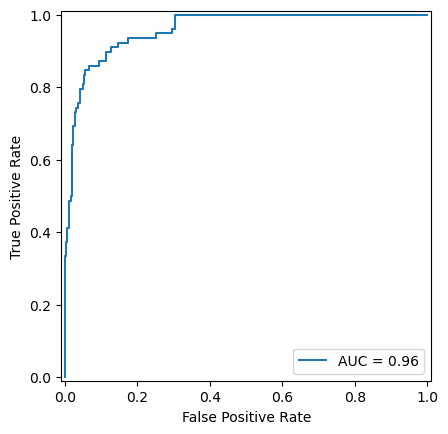

0.9271948608137045


In [427]:
model = best_model
with torch.no_grad():
    model.cpu()
    logits = model(
        torch.from_numpy(X_test).to(torch.float32)
    ).squeeze()

fpr, tpr, thresholds = roc_curve(ground_truth, logits)
auc = roc_auc_score(ground_truth, logits)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc).plot()
plt.show()
print(accuracy_score(ground_truth, get_preds(logits)))

In [398]:
best_threshold = thresholds[np.argmax(tpr - fpr)]
best_threshold

0.13871978

# XGBoost

In [428]:
import xgboost as xgb

n_estimators_to_try = [50, 100, 150, 200, 250]
lr_to_try = [1e-1, 1e-2, 1e-3, 1e-4]
max_depths_to_try = [3, 6, 9, 12]

best_xgb = None
best_acc = 0.0

for n_est in n_estimators_to_try:
    for lr in lr_to_try:
        for max_depth in max_depths_to_try:
            model = xgb.XGBClassifier(
                n_estimators=n_est, 
                learning_rate=lr, 
                max_depth=max_depth
            )
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)

        if accuracy > best_acc:
            best_xgb = model
            best_acc = accuracy

print(best_acc)

0.9271948608137045


# Support Vector Machines

In [409]:
from sklearn.svm import SVC

C_to_try = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
kernels_to_try = ['rbf', 'poly', 'sigmoid']

best_svm = None
best_acc = 0.0

for C in C_to_try:
    for kernel in kernels_to_try:
        svm = SVC(
            C=C,
            kernel=kernel, 
            probability=True
        )
        svm.fit(X_train, y_train)
        acc = accuracy_score(ground_truth, svm.predict(X_test))
        if acc > best_acc:
            best_acc = acc
            best_svm = svm

print(best_acc)

0.9122055674518201


# Random Forest

In [471]:
from sklearn.ensemble import RandomForestClassifier

n_estimators_to_try = [50, 100, 150, 200, 250]
criterions_to_try = ['gini', 'log_loss', 'entropy']
max_depths_to_try = [1, 3, 6, 9, 12, None]
max_features_to_try = ['sqrt', 'log2', None]

best_rf = None
best_acc = 0.0

for n_est in n_estimators_to_try:
    for criterion in criterions_to_try:
        for md in max_depths_to_try:
            for mf in max_features_to_try:
                rf = RandomForestClassifier(
                    n_estimators=n_est,
                    criterion=criterion,
                    max_depth=md,
                    max_features=mf
                )
                rf.fit(X_train, y_train)
                acc = accuracy_score(ground_truth, rf.predict(X_test))
                if acc > best_acc:
                    best_acc = acc
                    best_rf = rf

print(best_acc)

0.9293361884368309


# PCA + K-Nearest Neighbors

In [472]:
from sklearn.decomposition import PCA

pca = PCA(43)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_eval_pca = pca.transform(X_eval)
X_test_pca = pca.transform(X_test)

print('Post-PCA Feature Shapes:')
print(f'\ttrain: {X_train_pca.shape}')
print(f'\teval: {X_eval_pca.shape}')
print(f'\ttest: {X_test_pca.shape}')

Post-PCA Feature Shapes:
	train: (2795, 43)
	eval: (311, 43)
	test: (467, 43)


In [473]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors_to_try = [5, 11, 17, 25, 33, 41]
weights_to_try = ['uniform', 'distance']

best_knn = None
best_acc = 0.0

for k in n_neighbors_to_try:
    for weight in weights_to_try:
        knn = KNeighborsClassifier(
            n_neighbors=k,
            weights=weight
        )
        knn.fit(X_train_pca, y_train)
        acc = accuracy_score(ground_truth, knn.predict(X_test_pca))
        if acc > best_acc:
            best_acc = acc
            best_knn = knn

print(best_acc)

0.892933618843683


# Inference on Test Set

In [399]:
# drop non-feature columns
test_ids = test_csv.id
_TEST = test_csv.drop(['id'], axis=1)
# transform using pipeline
_TEST = engineer_features(_TEST)
_TEST = pipeline.transform(_TEST)
# _TEST = pca.transform(_TEST)

model = best_model
threshold = 0.5

with torch.no_grad():
    model.cpu()
    logits = model(torch.from_numpy(_TEST).to(torch.float32)).squeeze()

preds = get_preds(logits, threshold).numpy()

save_path = f"../preds/preds_{model.name}_andy_0802.csv".replace(' ', '_')

out = pd.DataFrame({
    'id': test_ids,
    'winner': convert(preds)
})

if save_path is not None:
    out.to_csv(
        save_path, index=False
    )

In [476]:
predictions = {'id': test_ids}

with torch.no_grad():
    best_model.cpu()
    logits = best_model(torch.from_numpy(_TEST).to(torch.float32)).squeeze()
predictions['nn'] = get_preds(logits).numpy()
predictions['xgb'] = best_xgb.predict(_TEST)
predictions['svm'] = best_svm.predict(_TEST)
predictions['rf'] = best_rf.predict(_TEST)
predictions['knn'] = best_knn.predict(pca.transform(_TEST))

predictions = pd.DataFrame.from_dict(predictions)
predictions['winner'] = predictions[['nn', 'xgb', 'svm', 'rf', 'knn']].mode(axis=1)
predictions['winner'] = predictions['winner'].apply(num2prez)
predictions[['id', 'winner']].to_csv(
    f'../preds/preds_ensemble_nn_xgb_svm_rf_knn_andy_0802.csv',
    index=False
)